Loading data...
Columns found: ['Source_File', 'Sheet_Name', 'Cycle', 'Peak1_Amp', 'Peak1_Pos', 'Peak1_Width', 'Peak2_Amp', 'Peak2_Pos', 'Peak2_Width', 'Peak3_Amp', 'Peak3_Pos', 'Peak3_Width']
Target 'g3' not found. Calculating RUL from 'Cycle' data...

Training on 9 features: ['Peak1_Amp', 'Peak1_Pos', 'Peak1_Width', 'Peak2_Amp', 'Peak2_Pos', 'Peak2_Width', 'Peak3_Amp', 'Peak3_Pos', 'Peak3_Width']
Predicting target: RUL

Starting training...
Epoch 1/128
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 315997.5312 - mean_absolute_error: 486.3073 - val_loss: 297724.7188 - val_mean_absolute_error: 456.4152
Epoch 2/128
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 302838.9062 - mean_absolute_error: 472.9853 - val_loss: 268295.9375 - val_mean_absolute_error: 426.8352
Epoch 3/128
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 242214.4219 - mean_absolute_error: 409.3660 - val_loss: 168797.5625 - val_mean_absolute_error: 331.0876
Epoch 4/128
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1310

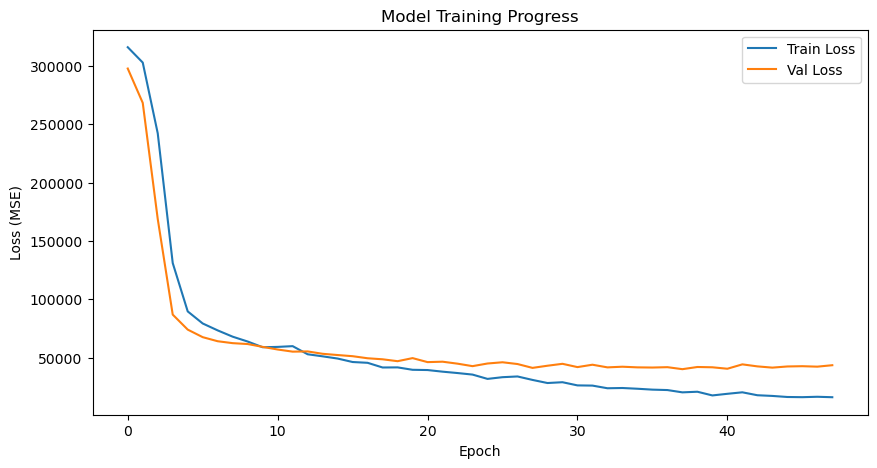

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def build_dnn_model(input_dim):
    # A simple but effective architecture for regression
    model = models.Sequential([
        layers.InputLayer(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),  # Helps prevent overfitting
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='linear') # Linear activation for regression (RUL)
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mean_absolute_error']
    )
    return model

# --- MAIN EXECUTION ---
if __name__ == "__main__":
    file_path = "Lorentzian_Features.csv" # Ensure this matches your filename
    
    print("Loading data...")
    df = pd.read_csv(file_path)
    
    # 1. Clean Column Names (remove hidden spaces)
    df.columns = df.columns.str.strip()
    print(f"Columns found: {list(df.columns)}")

    # 2. Generate Target (RUL) if 'g3' is missing
    target_col = 'RUL'
    
    if 'g3' in df.columns:
        print("Found target column 'g3'. Using it.")
        target_col = 'g3'
    else:
        print("Target 'g3' not found. Calculating RUL from 'Cycle' data...")
        # Calculate RUL: Max Cycle for that specific file - Current Cycle
        # We group by 'Source_File' so we don't mix up different batteries
        if 'Source_File' in df.columns and 'Cycle' in df.columns:
            max_cycles = df.groupby('Source_File')['Cycle'].transform('max')
            df['RUL'] = max_cycles - df['Cycle']
        else:
            # Fallback if Source_File is missing (assumes entire file is one battery)
            print("Warning: Could not group by Source_File. Assuming single battery.")
            df['RUL'] = df['Cycle'].max() - df['Cycle']

    # 3. Prepare Features (X) and Target (y)
    # We must drop non-numeric columns and the target itself
    cols_to_drop = ['Source_File', 'Sheet_Name', 'Cycle', target_col]
    
    # Only drop columns that actually exist
    existing_drop_cols = [c for c in cols_to_drop if c in df.columns]
    
    X = df.drop(columns=existing_drop_cols)
    y = df[target_col]

    print(f"\nTraining on {X.shape[1]} features: {list(X.columns)}")
    print(f"Predicting target: {target_col}")

    # 4. Scale the Data (Crucial for DNNs)
    # Features often vary in scale (e.g., Position is ~3.6, Amp is ~1000). 
    # Scaling makes training much faster and more accurate.
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 5. Split Data
    X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # 6. Train Model
    model = build_dnn_model(X_train.shape[1])
    
    print("\nStarting training...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=128,            # Increased epochs for better convergence
        batch_size=10,
        verbose=1,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
    )

    # 7. Evaluate
    print("\n--- Evaluation ---")
    predictions = model.predict(X_val).flatten()
    
    # Show first 5 comparisons
    results = pd.DataFrame({'Actual': y_val, 'Predicted': predictions})
    print(results.head())
    
    # Optional: Plot Loss Curve
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Training Progress')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.show()